# Feature Engineering for Eredivisie Match Prediction

This notebook focuses on the **Feature Engineering** phase of the football match prediction project. The goal of this project is to predict the outcome of football matches, specifically whether the result will be a **home win**, **draw**, or **away win**.

In this notebook, we will:

- Calculate the **dependent variable** (`home_win`, `draw`, `away_win`) based on historical match data.
- Engineer and prepare the **features** required for the predictive model.
    - `elo_rating`: Based on the methodology of ELO in chess we can calculate a rating per team that reflects the level of a certain team compared to the competition. For notation on the formula's used see: https://en.wikipedia.org/wiki/Elo_rating_system 
    - `elo_difference`: The difference in ELO rating between the opposing teams (reasoned from the `home_team`).
    - `form`: A wighted form score based on the last 5 matches, where the latest match weighs more than the last.
    - `goal_difference`: The goal difference over the last 5 matches.
    - `head_to_head`: The all time head to head home_wins, draws, away wins and goal difference between the two teams.
    - `last10_head_to_head`: The last 10 matchup head to head stats between the two teams.
    - `home_away_win_percentage`: The moving average of the last 17 (one full season) matches of home and away win percentages.

This step is crucial as it transforms raw data into meaningful inputs that enhance the model's performance.

**Future:** 
- Create wrapper function to be ran in the main.py script.

**Version:** 1.0


In [16]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter

# Set seaborn style for plots
sns.set(style="whitegrid")
sns.set_palette(sns.color_palette("pastel"))

## Functions:

In [17]:
def create_match_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to create match results from the dataframe.

    Returns: a DataFrame with two new columns:
        - 'match_result': 'home_win', 'away_win', or 'draw'
        - 'match_result_numeric': 1 for home win, -1 for away win, and 0 for draw.
    """
    # Create a new column 'match_result' based on the conditions
    df['match_result'] = np.where(df['home_score'] > df['away_score'], 'home_win',
                                   np.where(df['home_score'] < df['away_score'], 'away_win', 'draw'))

    # Create a new column 'match_result_numeric' based on the conditions
    df['match_result_numeric'] = np.where(df['home_score'] > df['away_score'], 1,
                                          np.where(df['home_score'] < df['away_score'], -1, 0))
    
    return df

In [18]:
def create_elo_rating(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to create Elo ratings for teams based on match results. 
    See: https://mattmazzola.medium.com/implementing-the-elo-rating-system-a085f178e065 
    for details on Elo rating calculation.

    Returns: a DataFrame with two new columns:
        - 'home_elo': Elo rating for the home team
        - 'away_elo': Elo rating for the away team
    """
    # Initialize Elo ratings for teams
    elo_ratings = {}

    # Create constants for Elo rating calculation
    initial_elo = 1000      # Initial Elo rating for all teams
    k_factor = 32           # K-factor for Elo rating calculation
    scale_factor = 400      # Scale factor for Elo rating calculation

    # Create new columns initialized with None
    df['home_elo'] = None
    df['away_elo'] = None

    for index, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        home_score = row['home_score']
        away_score = row['away_score']

        # Initialize Elo ratings for teams if not already present
        if home_team not in elo_ratings:
            elo_ratings[home_team] = initial_elo
        if away_team not in elo_ratings:
            elo_ratings[away_team] = initial_elo

        # Get current Elo ratings for teams (before updating)
        home_elo = elo_ratings[home_team]
        away_elo = elo_ratings[away_team]

        # Store the current Elo ratings in the DataFrame
        df.at[index, 'home_elo'] = home_elo
        df.at[index, 'away_elo'] = away_elo

        # Calculate expected probability of winning for home and away teams
        expected_home = 1 / (1 + 10 ** ((away_elo - home_elo) / scale_factor))
        expected_away = 1 / (1 + 10 ** ((home_elo - away_elo) / scale_factor))

        # Calculate actual score for home and away teams
        if home_score > away_score:
            actual_home = 1
            actual_away = 0
        elif home_score < away_score:
            actual_home = 0
            actual_away = 1
        else:
            actual_home = 0.5
            actual_away = 0.5

        # Update Elo ratings for home and away teams (for future matches)
        elo_ratings[home_team] += k_factor * (actual_home - expected_home)
        elo_ratings[away_team] += k_factor * (actual_away - expected_away)

    return df

In [19]:
def create_difference_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to create Elo difference between home and away teams.

    Returns: a DataFrame with a new column:
        - 'elo_difference': Difference between home and away team Elo ratings.
    """
    # Create a new column 'elo_difference' based on the difference between home and away Elo ratings
    df['elo_difference'] = df['home_elo'] - df['away_elo']

    # Create a new column 'form_score_difference' based on the difference between home and away form scores
    df['form_score_difference'] = df['home_form_score'] - df['away_form_score']
    
    return df

In [20]:
def create_form_score(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to create form score for teams based on the last 5 matches.
    The form is calculated based on a weighted average where the latest match carries more weight.
    The same form score is used for both home and away matches, placed in the appropriate column.

    Returns: a DataFrame with form_score columns for home and away teams.
    """
    # Initialize form score for teams (single form score per team)
    team_form = {}  # Key: team name, Value: list of last 5 match points

    # Create new columns initialized with None
    df['home_form_score'] = None
    df['away_form_score'] = None

    # Set the weights for the last 5 matches (latest first)
    weights = [2, 1.6, 1.4, 1.2, 1]  

    for index, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']

        # Initialize form score for teams if not already present
        if home_team not in team_form:
            team_form[home_team] = []
        if away_team not in team_form:
            team_form[away_team] = []

        # Calculate form scores BEFORE adding current match (to avoid lookahead bias)
        # Only calculate if team has at least one previous match
        if team_form[home_team]:
            home_team_form = np.dot(
                weights[-len(team_form[home_team]):],
                team_form[home_team][-len(weights):]
            )
            df.at[index, 'home_form_score'] = home_team_form
            
        if team_form[away_team]:
            away_team_form = np.dot(
                weights[-len(team_form[away_team]):],
                team_form[away_team][-len(weights):]
            )
            df.at[index, 'away_form_score'] = away_team_form

        # Append the current match result to the form score lists AFTER calculating form
        if row['match_result'] == 'home_win':
            team_form[home_team].append(3)
            team_form[away_team].append(0)
        elif row['match_result'] == 'away_win':
            team_form[home_team].append(0)
            team_form[away_team].append(3)
        else:  # Draw
            team_form[home_team].append(1)
            team_form[away_team].append(1)

        # Keep only the last 5 matches in the form score list
        if len(team_form[home_team]) > 5:
            team_form[home_team].pop(0)
        if len(team_form[away_team]) > 5:
            team_form[away_team].pop(0)

    return df

In [21]:
def create_goal_difference(df: pd.DataFrame) -> pd.DataFrame:
    """"
    Calculate the goal difference per team over the last 5 matches.

    Returns: a DataFrame with goal_difference columns for home and away teams.
    """
    # Initialize form score for teams (single form score per team)
    team_goal_difference = {}  # Key: team name, Value: list of last 5 match points

    # Create new columns initialized with None
    df['home_goal_difference'] = None
    df['away_goal_difference'] = None

    for index, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']

        # Initialize goal difference for teams if not already present
        if home_team not in team_goal_difference:
            team_goal_difference[home_team] = []
        if away_team not in team_goal_difference:
            team_goal_difference[away_team] = []

        # Calculate goal difference for home and away teams
        if len(team_goal_difference[home_team]) > 0:
            df.at[index, 'home_goal_difference'] = sum(team_goal_difference[home_team])
        if len(team_goal_difference[away_team]) > 0:
            df.at[index, 'away_goal_difference'] = sum(team_goal_difference[away_team])

        # Append the current match result to the form score lists AFTER calculating form
        team_goal_difference[home_team].append(row['home_score'] - row['away_score'])
        team_goal_difference[away_team].append(row['away_score'] - row['home_score'])

        # Keep only the last 5 matches in the form score list
        if len(team_goal_difference[home_team]) > 5:
            team_goal_difference[home_team].pop(0)
        if len(team_goal_difference[away_team]) > 5:
            team_goal_difference[away_team].pop(0)

    return df

In [22]:
def create_head_to_head_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function to create head-to-head statistics between teams, including:
    - All-time H2H records
    - Last 10 matches H2H records
    
    Returns: DataFrame with new H2H columns
    """
    # Initialize dictionaries to store H2H records
    h2h_all_time = {}  # Format: {(home, away): {'home_wins': x, 'away_wins': y, 'draws': z, 'goal_diff': n}}
    h2h_last_10 = {}    # Same format but only keeps last 10 matches
    
    # Create new columns initialized with 0
    # All-time stats
    df['h2h_home_wins'] = 0
    df['h2h_away_wins'] = 0
    df['h2h_draws'] = 0
    df['h2h_goal_diff'] = 0
    
    # Last 10 matches stats
    df['last10_h2h_home_wins'] = 0
    df['last10_h2h_away_wins'] = 0
    df['last10_h2h_draws'] = 0
    df['last10_h2h_goal_diff'] = 0

    for index, row in df.sort_values('date').iterrows():  # Ensure chronological processing
        home_team = row['home_team']
        away_team = row['away_team']
        matchup_key = (home_team, away_team)
        
        # Initialize records if not present
        if matchup_key not in h2h_all_time:
            h2h_all_time[matchup_key] = {
                'home_wins': 0,
                'away_wins': 0,
                'draws': 0,
                'goal_diff': 0,
                'matches': []  # Store match results for last 10 calculation
            }
        
        if matchup_key not in h2h_last_10:
            h2h_last_10[matchup_key] = {
                'home_wins': 0,
                'away_wins': 0,
                'draws': 0,
                'goal_diff': 0
            }
        
        # Store current H2H stats BEFORE updating (avoid lookahead bias)
        df.at[index, 'h2h_home_wins'] = h2h_all_time[matchup_key]['home_wins']
        df.at[index, 'h2h_away_wins'] = h2h_all_time[matchup_key]['away_wins']
        df.at[index, 'h2h_draws'] = h2h_all_time[matchup_key]['draws']
        df.at[index, 'h2h_goal_diff'] = h2h_all_time[matchup_key]['goal_diff']
        
        df.at[index, 'last10_h2h_home_wins'] = h2h_last_10[matchup_key]['home_wins']
        df.at[index, 'last10_h2h_away_wins'] = h2h_last_10[matchup_key]['away_wins']
        df.at[index, 'last10_h2h_draws'] = h2h_last_10[matchup_key]['draws']
        df.at[index, 'last10_h2h_goal_diff'] = h2h_last_10[matchup_key]['goal_diff']
        
        # Update H2H records AFTER storing current values
        goal_diff = row['home_score'] - row['away_score']
        
        # Update all-time records
        if row['match_result'] == 'home_win':
            h2h_all_time[matchup_key]['home_wins'] += 1
        elif row['match_result'] == 'away_win':
            h2h_all_time[matchup_key]['away_wins'] += 1
        else:
            h2h_all_time[matchup_key]['draws'] += 1
        h2h_all_time[matchup_key]['goal_diff'] += goal_diff
        
        # Store match for last 10 calculation
        h2h_all_time[matchup_key]['matches'].append({
            'result': row['match_result'],
            'goal_diff': goal_diff
        })
        
        # Update last 10 records
        last_10_matches = h2h_all_time[matchup_key]['matches'][-10:]
        
        # Recalculate last 10 stats
        home_wins = sum(1 for m in last_10_matches if m['result'] == 'home_win')
        away_wins = sum(1 for m in last_10_matches if m['result'] == 'away_win')
        draws = sum(1 for m in last_10_matches if m['result'] == 'draw')
        total_gd = sum(m['goal_diff'] for m in last_10_matches)
        
        h2h_last_10[matchup_key] = {
            'home_wins': home_wins,
            'away_wins': away_wins,
            'draws': draws,
            'goal_diff': total_gd
        }

    return df

In [23]:
def home_away_performance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates 17-match moving averages for:
    - Home team's home win percentage
    - Away team's away win percentage
    
    Returns DataFrame with new columns:
    - home_team_home_win_pct: Home team's win % in last 17 home matches
    - away_team_away_win_pct: Away team's win % in last 17 away matches
    """
    # Initialize dictionaries to store match histories
    home_team_history = {}  # {team: list of home match results}
    away_team_history = {}  # {team: list of away match results}
    
    # Create new columns initialized with None
    df['home_team_home_win_pct'] = None
    df['away_team_away_win_pct'] = None
    
    # Ensure chronological processing
    df = df.sort_values('date').reset_index(drop=True)
    
    for index, row in df.iterrows():
        home_team = row['home_team']
        away_team = row['away_team']
        
        # Initialize histories if needed
        if home_team not in home_team_history:
            home_team_history[home_team] = []
        if away_team not in away_team_history:
            away_team_history[away_team] = []
        
        # Calculate win percentages BEFORE adding current match
        home_last_17 = home_team_history[home_team][-17:]
        away_last_17 = away_team_history[away_team][-17:]
        
        if home_last_17:
            home_wins = sum(1 for result in home_last_17 if result == 'win')
            df.at[index, 'home_team_home_win_pct'] = home_wins / min(17, len(home_last_17))
        
        if away_last_17:
            away_wins = sum(1 for result in away_last_17 if result == 'win')
            df.at[index, 'away_team_away_win_pct'] = away_wins / min(17, len(away_last_17))
        
        # Add current match results to histories AFTER calculating
        # For home team's home history
        if row['match_result'] == 'home_win':
            home_team_history[home_team].append('win')
        elif row['match_result'] == 'away_win':
            home_team_history[home_team].append('loss')
        else:
            home_team_history[home_team].append('draw')
        
        # For away team's away history
        if row['match_result'] == 'away_win':
            away_team_history[away_team].append('win')
        elif row['match_result'] == 'home_win':
            away_team_history[away_team].append('loss')
        else:
            away_team_history[away_team].append('draw')
    
    return df

In [24]:
def display_new_column(df: pd.DataFrame, 
                    column_name_1: str, 
                    column_name_2: str,
                    output_column_name: str) -> None:
    """
    Function to display the new column in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to display the new column from.
        column_name_1 (str): The first column name to display.
        column_name_2 (str): The second column name to display.
        output_column_name (str): The name of the new column to display.

    """
    # Get the current goal_difference of all teams
    current_season = df[df_eredivisie_results['season'] == df['season'].max()]

    # Melt the dataframe to combine home and away form scores
    df_current_season_melted = current_season.melt(id_vars=['date', 'home_team', 'away_team', 'season'], 
                                                value_vars=[column_name_1, column_name_2], 
                                                var_name='team_type', 
                                                value_name=output_column_name)

    # Sort the values by date
    df_current_season_melted = df_current_season_melted.sort_values(by='date').reset_index(drop=True)

    # Correctly assign the team name to each row
    df_current_season_melted['team'] = df_current_season_melted.apply(
        lambda x: x['home_team'] if x['team_type'] == column_name_1 else x['away_team'],
        axis=1
    )

    # Get the latest form score for each team
    current_form_ranking = df_current_season_melted.groupby('team').last().reset_index().sort_values(by=output_column_name, ascending=False)

    # Show the current form ranking
    display(current_form_ranking[['team', output_column_name]].reset_index(drop=True))

## Analysis:

In [25]:
# Import the data
df_eredivisie_results = pd.read_csv('../Files/eredivisie_results_cleaned.csv')

df_eredivisie_results.head(10)

,season,date,home_team,away_team,home_score,away_score
0,1956-1957,1956-09-02,Ajax,NAC Breda,1,0
1,1956-1957,1956-09-02,BVV Den Bosch,Elinkwijk,1,2
2,1956-1957,1956-09-02,DOS,Sparta Rotterdam,2,3
3,1956-1957,1956-09-02,Fortuna Sittard,Eindhoven,4,1
4,1956-1957,1956-09-02,NOAD,BVC Amsterdam,1,3
5,1956-1957,1956-09-02,PSV,MVV,1,3
6,1956-1957,1956-09-02,SC Enschede,Roda JC,5,2
7,1956-1957,1956-09-02,VVV-Venlo,GVAV,1,0
8,1956-1957,1956-09-02,Willem II,Feyenoord,3,3
9,1956-1957,1956-09-09,BVC Amsterdam,Willem II,0,6


In [26]:
# Create the match result columns
df_eredivisie_results = create_match_results(df_eredivisie_results)

df_eredivisie_results.head(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric
0,1956-1957,1956-09-02,Ajax,NAC Breda,1,0,home_win,1
1,1956-1957,1956-09-02,BVV Den Bosch,Elinkwijk,1,2,away_win,-1
2,1956-1957,1956-09-02,DOS,Sparta Rotterdam,2,3,away_win,-1
3,1956-1957,1956-09-02,Fortuna Sittard,Eindhoven,4,1,home_win,1
4,1956-1957,1956-09-02,NOAD,BVC Amsterdam,1,3,away_win,-1
5,1956-1957,1956-09-02,PSV,MVV,1,3,away_win,-1
6,1956-1957,1956-09-02,SC Enschede,Roda JC,5,2,home_win,1
7,1956-1957,1956-09-02,VVV-Venlo,GVAV,1,0,home_win,1
8,1956-1957,1956-09-02,Willem II,Feyenoord,3,3,draw,0
9,1956-1957,1956-09-09,BVC Amsterdam,Willem II,0,6,away_win,-1


In [27]:
# Create the Elo ratings
df_eredivisie_results = create_elo_rating(df_eredivisie_results)

df_eredivisie_results.tail(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric,home_elo,away_elo
20712,2024-2025,2025-04-02,Feyenoord,FC Groningen,4,1,home_win,1,1331.919708,1021.329388
20713,2024-2025,2025-04-04,SC Heerenveen,Willem II,3,1,home_win,1,1061.028778,966.766554
20714,2024-2025,2025-04-05,Almere City FC,PEC Zwolle,2,2,draw,0,968.033426,1047.887041
20715,2024-2025,2025-04-05,AZ,Feyenoord,0,1,away_win,-1,1220.180351,1336.506274
20716,2024-2025,2025-04-05,FC Groningen,PSV,1,3,away_win,-1,1016.742822,1345.961043
20717,2024-2025,2025-04-05,FC Twente,Fortuna Sittard,1,1,draw,0,1192.676632,1032.93182
20718,2024-2025,2025-04-06,Ajax,NAC Breda,3,1,home_win,1,1356.540585,999.746275
20719,2024-2025,2025-04-06,Go Ahead Eagles,FC Utrecht,2,2,draw,0,1169.987506,1218.057353
20720,2024-2025,2025-04-06,RKC Waalwijk,Heracles Almelo,0,0,draw,0,966.019697,1062.068433
20721,2024-2025,2025-04-06,Sparta Rotterdam,NEC,2,0,home_win,1,1071.45574,1097.484001


In [28]:
# Melt the dataframe to combine home and away Elo ratings
df_elo_melted = df_eredivisie_results.melt(id_vars=['date', 'home_team', 'away_team', 'season'], 
                                             value_vars=['home_elo', 'away_elo'], 
                                             var_name='team_type', 
                                             value_name='elo_rating')

# Sort the values by date
df_elo_melted = df_elo_melted.sort_values(by='date').reset_index(drop=True)

# Assign the correct team name to each row
df_elo_melted['team'] = df_elo_melted.apply(
    lambda x: x['home_team'] if x['team_type'] == 'home_elo' else x['away_team'],
    axis=1
)

# Drop unnecessary columns
df_elo_melted = df_elo_melted.drop(columns=['home_team', 'away_team', 'team_type'])

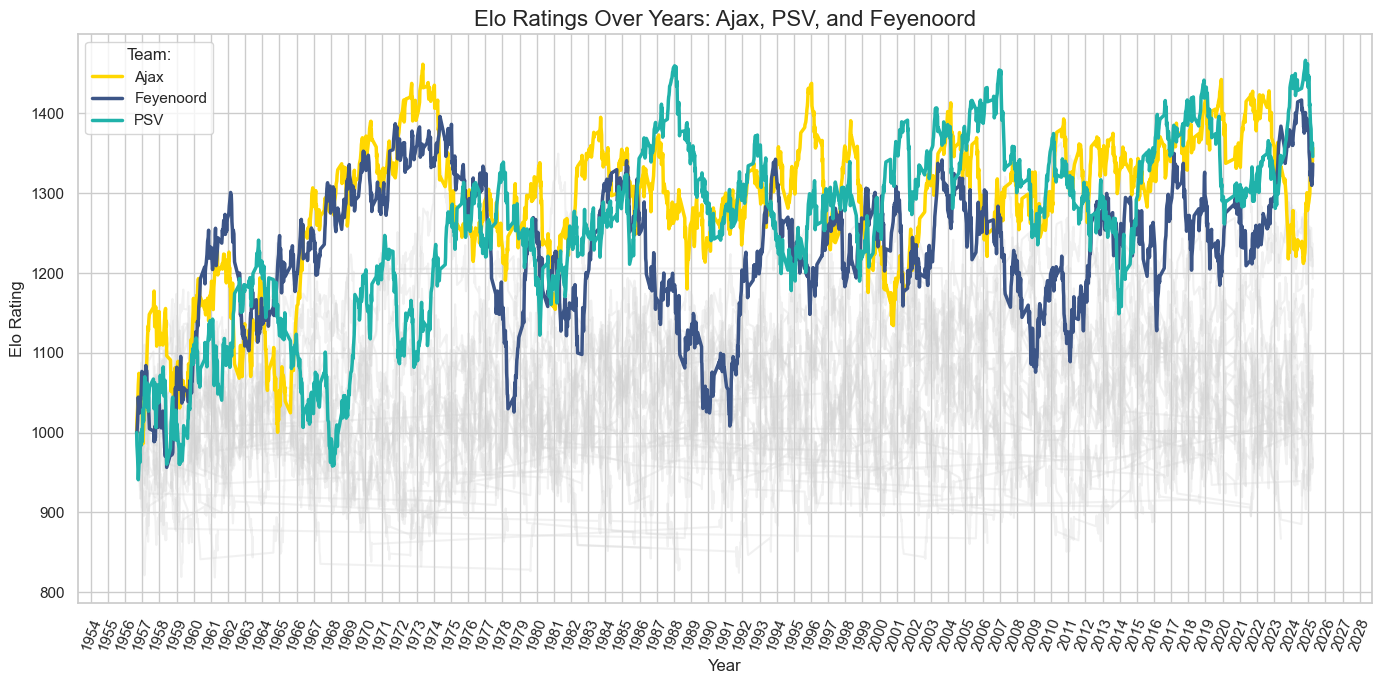

In [29]:
# Ensure 'date' is datetime
df_elo_melted['date'] = pd.to_datetime(df_elo_melted['date'])

# Filter for highlighted teams
highlight_teams = ['Ajax', 'PSV', 'Feyenoord']
df_highlight = df_elo_melted[df_elo_melted['team'].isin(highlight_teams)]
df_other = df_elo_melted[~df_elo_melted['team'].isin(highlight_teams)]

# Create plot
plt.figure(figsize=(14, 7))

# Plot other teams (faint background)
sns.lineplot(
    data=df_other,
    x='date',  # Use actual datetime values
    y='elo_rating',
    hue='team',
    palette=['lightgray'] * len(df_other['team'].unique()),
    alpha=0.3,
    legend=False
)

# Plot highlighted teams
sns.lineplot(
    data=df_highlight,
    x='date',
    y='elo_rating',
    hue='team',
    palette = ["gold", "#3c5587", "lightseagreen"],
    linewidth=2.5,
    estimator=None
)

# Configure x-axis to show years
ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator())  # Tick every year
ax.xaxis.set_major_formatter(DateFormatter('%Y'))  # Format as just year

plt.title('Elo Ratings Over Years: Ajax, PSV, and Feyenoord', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Elo Rating', fontsize=12)
plt.legend(title='Team:')

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [30]:
# Show the current ranking by Elo rating
display_new_column(df_eredivisie_results,
                    'home_elo',
                    'away_elo',
                    'elo_rating')

,team,elo_rating
0,Ajax,1356.540585
1,PSV,1345.961043
2,Feyenoord,1336.506274
3,AZ,1220.180351
4,FC Utrecht,1218.057353
5,FC Twente,1192.676632
6,Go Ahead Eagles,1169.987506
7,NEC,1097.484001
8,Sparta Rotterdam,1071.45574
9,Heracles Almelo,1062.068433


In [31]:
# Calculate the form score
df_eredivisie_results = create_form_score(df_eredivisie_results)

df_eredivisie_results.tail(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric,home_elo,away_elo,home_form_score,away_form_score
20712,2024-2025,2025-04-02,Feyenoord,FC Groningen,4,1,home_win,1,1331.919708,1021.329388,14.8,16.8
20713,2024-2025,2025-04-04,SC Heerenveen,Willem II,3,1,home_win,1,1061.028778,966.766554,8.0,0.0
20714,2024-2025,2025-04-05,Almere City FC,PEC Zwolle,2,2,draw,0,968.033426,1047.887041,4.2,6.2
20715,2024-2025,2025-04-05,AZ,Feyenoord,0,1,away_win,-1,1220.180351,1336.506274,9.6,18.4
20716,2024-2025,2025-04-05,FC Groningen,PSV,1,3,away_win,-1,1016.742822,1345.961043,13.0,9.8
20717,2024-2025,2025-04-05,FC Twente,Fortuna Sittard,1,1,draw,0,1192.676632,1032.93182,11.8,9.0
20718,2024-2025,2025-04-06,Ajax,NAC Breda,3,1,home_win,1,1356.540585,999.746275,19.2,5.6
20719,2024-2025,2025-04-06,Go Ahead Eagles,FC Utrecht,2,2,draw,0,1169.987506,1218.057353,12.6,14.0
20720,2024-2025,2025-04-06,RKC Waalwijk,Heracles Almelo,0,0,draw,0,966.019697,1062.068433,1.0,9.0
20721,2024-2025,2025-04-06,Sparta Rotterdam,NEC,2,0,home_win,1,1071.45574,1097.484001,10.4,6.2


In [32]:
# Show the current form of all teams over the last 5 matches
display_new_column(df_eredivisie_results,
                    'home_form_score',
                    'away_form_score',
                    'form_score')

,team,form_score
0,Ajax,19.2
1,Feyenoord,18.4
2,FC Utrecht,14.0
3,FC Groningen,13.0
4,Go Ahead Eagles,12.6
5,FC Twente,11.8
6,Sparta Rotterdam,10.4
7,PSV,9.8
8,AZ,9.6
9,Heracles Almelo,9.0


In [33]:
# Crete the goal difference
df_eredivisie_results = create_goal_difference(df_eredivisie_results)

df_eredivisie_results.tail(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric,home_elo,away_elo,home_form_score,away_form_score,home_goal_difference,away_goal_difference
20712,2024-2025,2025-04-02,Feyenoord,FC Groningen,4,1,home_win,1,1331.919708,1021.329388,14.8,16.8,6,4
20713,2024-2025,2025-04-04,SC Heerenveen,Willem II,3,1,home_win,1,1061.028778,966.766554,8.0,0.0,-1,-10
20714,2024-2025,2025-04-05,Almere City FC,PEC Zwolle,2,2,draw,0,968.033426,1047.887041,4.2,6.2,-1,-1
20715,2024-2025,2025-04-05,AZ,Feyenoord,0,1,away_win,-1,1220.180351,1336.506274,9.6,18.4,-1,9
20716,2024-2025,2025-04-05,FC Groningen,PSV,1,3,away_win,-1,1016.742822,1345.961043,13.0,9.8,0,1
20717,2024-2025,2025-04-05,FC Twente,Fortuna Sittard,1,1,draw,0,1192.676632,1032.93182,11.8,9.0,-2,-3
20718,2024-2025,2025-04-06,Ajax,NAC Breda,3,1,home_win,1,1356.540585,999.746275,19.2,5.6,6,-1
20719,2024-2025,2025-04-06,Go Ahead Eagles,FC Utrecht,2,2,draw,0,1169.987506,1218.057353,12.6,14.0,0,3
20720,2024-2025,2025-04-06,RKC Waalwijk,Heracles Almelo,0,0,draw,0,966.019697,1062.068433,1.0,9.0,-8,-2
20721,2024-2025,2025-04-06,Sparta Rotterdam,NEC,2,0,home_win,1,1071.45574,1097.484001,10.4,6.2,6,-2


In [34]:
# Show the current goal difference of all teams over the last 5 matches
display_new_column(df_eredivisie_results,
                    'home_goal_difference', 
                    'away_goal_difference',
                    'goal_difference')

,team,goal_difference
0,Feyenoord,9
1,Sparta Rotterdam,6
2,Ajax,6
3,FC Utrecht,3
4,PSV,1
5,FC Groningen,0
6,Go Ahead Eagles,0
7,AZ,-1
8,PEC Zwolle,-1
9,Almere City FC,-1


In [35]:
# Calculate the head-to-head statistics
df_eredivisie_results = create_head_to_head_stats(df_eredivisie_results)

df_eredivisie_results.tail(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric,home_elo,away_elo,...,home_goal_difference,away_goal_difference,h2h_home_wins,h2h_away_wins,h2h_draws,h2h_goal_diff,last10_h2h_home_wins,last10_h2h_away_wins,last10_h2h_draws,last10_h2h_goal_diff
20712,2024-2025,2025-04-02,Feyenoord,FC Groningen,4,1,home_win,1,1331.919708,1021.329388,...,6,4,30,3,10,61,8,0,2,15
20713,2024-2025,2025-04-04,SC Heerenveen,Willem II,3,1,home_win,1,1061.028778,966.766554,...,-1,-10,15,5,8,25,8,1,1,15
20714,2024-2025,2025-04-05,Almere City FC,PEC Zwolle,2,2,draw,0,968.033426,1047.887041,...,-1,-1,0,1,0,-1,0,1,0,-1
20715,2024-2025,2025-04-05,AZ,Feyenoord,0,1,away_win,-1,1220.180351,1336.506274,...,-1,9,12,19,15,-23,3,5,2,-9
20716,2024-2025,2025-04-05,FC Groningen,PSV,1,3,away_win,-1,1016.742822,1345.961043,...,0,1,11,22,11,-17,2,5,3,-5
20717,2024-2025,2025-04-05,FC Twente,Fortuna Sittard,1,1,draw,0,1192.676632,1032.93182,...,-2,-3,16,2,6,29,6,1,3,11
20718,2024-2025,2025-04-06,Ajax,NAC Breda,3,1,home_win,1,1356.540585,999.746275,...,6,-1,40,3,7,116,7,1,2,26
20719,2024-2025,2025-04-06,Go Ahead Eagles,FC Utrecht,2,2,draw,0,1169.987506,1218.057353,...,0,3,11,9,7,7,2,5,3,-3
20720,2024-2025,2025-04-06,RKC Waalwijk,Heracles Almelo,0,0,draw,0,966.019697,1062.068433,...,-8,-2,4,4,2,2,4,4,2,2
20721,2024-2025,2025-04-06,Sparta Rotterdam,NEC,2,0,home_win,1,1071.45574,1097.484001,...,6,-2,24,6,5,28,4,3,3,-1


In [36]:
# Calculate the home and away performance
df_eredivisie_results = home_away_performance(df_eredivisie_results)

df_eredivisie_results.tail(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric,home_elo,away_elo,...,h2h_home_wins,h2h_away_wins,h2h_draws,h2h_goal_diff,last10_h2h_home_wins,last10_h2h_away_wins,last10_h2h_draws,last10_h2h_goal_diff,home_team_home_win_pct,away_team_away_win_pct
20712,2024-2025,2025-04-02,Feyenoord,FC Groningen,4,1,home_win,1,1331.919708,1021.329388,...,30,3,10,61,8,0,2,15,0.705882,0.117647
20713,2024-2025,2025-04-04,SC Heerenveen,Willem II,3,1,home_win,1,1061.028778,966.766554,...,15,5,8,25,8,1,1,15,0.352941,0.176471
20714,2024-2025,2025-04-05,FC Groningen,PSV,1,3,away_win,-1,1016.742822,1345.961043,...,11,22,11,-17,2,5,3,-5,0.352941,0.588235
20715,2024-2025,2025-04-05,FC Twente,Fortuna Sittard,1,1,draw,0,1192.676632,1032.93182,...,16,2,6,29,6,1,3,11,0.764706,0.176471
20716,2024-2025,2025-04-05,Almere City FC,PEC Zwolle,2,2,draw,0,968.033426,1047.887041,...,0,1,0,-1,0,1,0,-1,0.117647,0.058824
20717,2024-2025,2025-04-05,AZ,Feyenoord,0,1,away_win,-1,1220.180351,1336.506274,...,12,19,15,-23,3,5,2,-9,0.588235,0.529412
20718,2024-2025,2025-04-06,Go Ahead Eagles,FC Utrecht,2,2,draw,0,1169.987506,1218.057353,...,11,9,7,7,2,5,3,-3,0.529412,0.529412
20719,2024-2025,2025-04-06,RKC Waalwijk,Heracles Almelo,0,0,draw,0,966.019697,1062.068433,...,4,4,2,2,4,4,2,2,0.176471,0.176471
20720,2024-2025,2025-04-06,Ajax,NAC Breda,3,1,home_win,1,1356.540585,999.746275,...,40,3,7,116,7,1,2,26,0.764706,0.176471
20721,2024-2025,2025-04-06,Sparta Rotterdam,NEC,2,0,home_win,1,1071.45574,1097.484001,...,24,6,5,28,4,3,3,-1,0.294118,0.411765


In [37]:
# Create difference scores
df_eredivisie_results = create_difference_scores(df_eredivisie_results)

df_eredivisie_results.tail(10)

,season,date,home_team,away_team,home_score,away_score,match_result,match_result_numeric,home_elo,away_elo,...,h2h_draws,h2h_goal_diff,last10_h2h_home_wins,last10_h2h_away_wins,last10_h2h_draws,last10_h2h_goal_diff,home_team_home_win_pct,away_team_away_win_pct,elo_difference,form_score_difference
20712,2024-2025,2025-04-02,Feyenoord,FC Groningen,4,1,home_win,1,1331.919708,1021.329388,...,10,61,8,0,2,15,0.705882,0.117647,310.59032,-2.0
20713,2024-2025,2025-04-04,SC Heerenveen,Willem II,3,1,home_win,1,1061.028778,966.766554,...,8,25,8,1,1,15,0.352941,0.176471,94.262223,8.0
20714,2024-2025,2025-04-05,FC Groningen,PSV,1,3,away_win,-1,1016.742822,1345.961043,...,11,-17,2,5,3,-5,0.352941,0.588235,-329.218221,3.2
20715,2024-2025,2025-04-05,FC Twente,Fortuna Sittard,1,1,draw,0,1192.676632,1032.93182,...,6,29,6,1,3,11,0.764706,0.176471,159.744812,2.8
20716,2024-2025,2025-04-05,Almere City FC,PEC Zwolle,2,2,draw,0,968.033426,1047.887041,...,0,-1,0,1,0,-1,0.117647,0.058824,-79.853615,-2.0
20717,2024-2025,2025-04-05,AZ,Feyenoord,0,1,away_win,-1,1220.180351,1336.506274,...,15,-23,3,5,2,-9,0.588235,0.529412,-116.325923,-8.8
20718,2024-2025,2025-04-06,Go Ahead Eagles,FC Utrecht,2,2,draw,0,1169.987506,1218.057353,...,7,7,2,5,3,-3,0.529412,0.529412,-48.069846,-1.4
20719,2024-2025,2025-04-06,RKC Waalwijk,Heracles Almelo,0,0,draw,0,966.019697,1062.068433,...,2,2,4,4,2,2,0.176471,0.176471,-96.048736,-8.0
20720,2024-2025,2025-04-06,Ajax,NAC Breda,3,1,home_win,1,1356.540585,999.746275,...,7,116,7,1,2,26,0.764706,0.176471,356.79431,13.6
20721,2024-2025,2025-04-06,Sparta Rotterdam,NEC,2,0,home_win,1,1071.45574,1097.484001,...,5,28,4,3,3,-1,0.294118,0.411765,-26.028261,4.2


In [38]:
# Save to csv
df_eredivisie_results.to_csv('../Files/eredivisie_results_features.csv', index=False)